# Experiment Comparison: Hard vs Soft Labels

This notebook loads results from different experiments and compares them side-by-side.

**Experiments to compare:**
- `results/hard_labels/` - Baseline (hard one-hot labels)
- `results/soft_gaussian_sigma2.0/` - Soft labels with Gaussian kernel (σ=2.0)
- `results/soft_gaussian_sigma1.0/` - Soft labels with Gaussian kernel (σ=1.0)
- `results/soft_triangular_radius3/` - Soft labels with triangular kernel (r=3)

In [17]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
%matplotlib inline

## 1. Load All Experiment Results

In [18]:
# Auto-discover all experiments
results_dir = Path("results")
experiments = {}

if results_dir.exists():
    for exp_path in results_dir.iterdir():
        if exp_path.is_dir():
            config_file = exp_path / "config.json"
            if config_file.exists():
                with open(config_file) as f:
                    config = json.load(f)
                
                # Load transition model history
                trans_hist_file = exp_path / "metrics" / "transition_model_history.json"
                if trans_hist_file.exists():
                    with open(trans_hist_file) as f:
                        trans_hist = json.load(f)
                else:
                    trans_hist = None
                
                # Load baseline model history
                base_hist_file = exp_path / "metrics" / "baseline_model_history.json"
                if base_hist_file.exists():
                    with open(base_hist_file) as f:
                        base_hist = json.load(f)
                else:
                    base_hist = None
                
                experiments[exp_path.name] = {
                    "config": config,
                    "transition": trans_hist,
                    "baseline": base_hist,
                    "path": exp_path
                }

print(f"Found {len(experiments)} experiments:")
for name in experiments.keys():
    print(f"  - {name}")

Found 3 experiments:
  - hard_labels
  - soft_gaussian_sigma1.0
  - soft_gaussian_sigma2.0


## 2. Summary Table

In [19]:
# Create summary table
summary_data = []

for exp_name, exp_data in experiments.items():
    config = exp_data["config"]
    trans = exp_data["transition"]
    base = exp_data["baseline"]
    
    if trans:
        row = {
            "Experiment": exp_name,
            "Soft Labels": config["use_soft_labels"],
            "Kernel": config.get("soft_label_kernel", "N/A"),
            "Sigma/Radius": config.get("soft_label_sigma") or config.get("soft_label_radius"),
            "Trans Test Loss": f"{trans['test_loss']:.4f}",
            "Trans Test Acc": f"{trans['test_acc']*100:.2f}%",
            "Trans Test Severity": f"{trans.get('test_severity', 'N/A')}",
        }
        if base:
            row["Base Test Loss"] = f"{base['test_loss']:.4f}"
            row["Base Test Acc"] = f"{base['test_acc']*100:.2f}%"
            row["Base Test Severity"] = f"{base.get('test_severity', 'N/A')}"
        
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("EXPERIMENT SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)


EXPERIMENT SUMMARY
            Experiment  Soft Labels   Kernel  Sigma/Radius Trans Test Loss Trans Test Acc Trans Test Severity Base Test Loss Base Test Acc Base Test Severity
           hard_labels        False gaussian           1.0          4.7084          3.09%   8.350010871887207         4.1898         2.53%                N/A
soft_gaussian_sigma1.0         True gaussian           1.0          2.4166          4.21%   8.245039939880371         2.4225         4.78%  8.214766502380371
soft_gaussian_sigma2.0         True gaussian           2.0          1.7351          3.93%   8.248446464538574         1.7230         3.65%  8.198734283447266


## 3. Test Accuracy Comparison

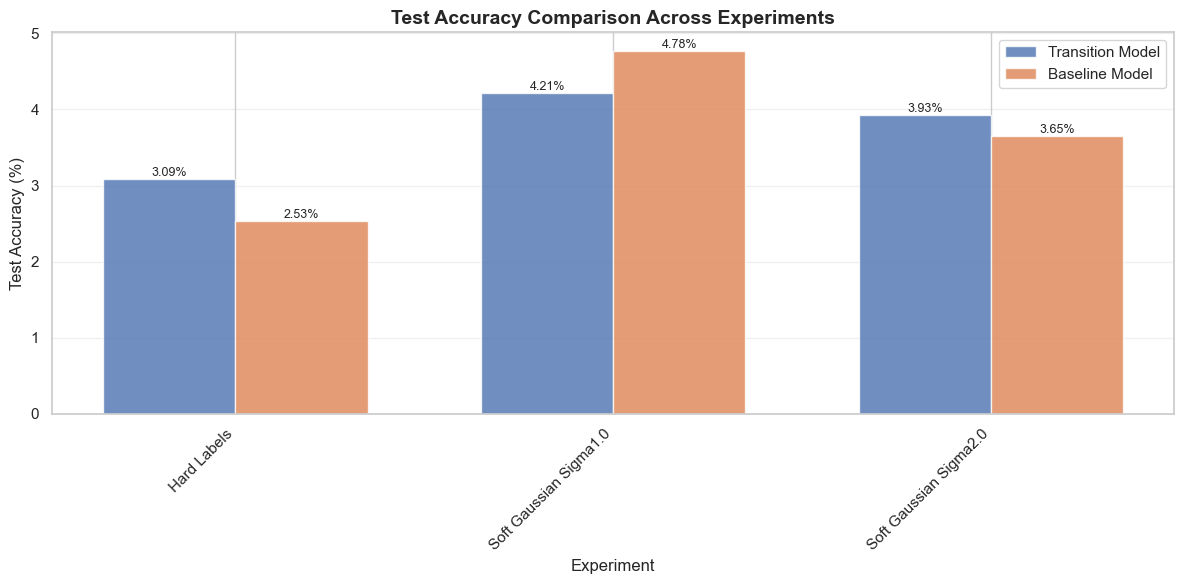

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

exp_names = []
trans_accs = []
base_accs = []

for exp_name, exp_data in experiments.items():
    if exp_data["transition"]:
        exp_names.append(exp_name.replace("_", " ").title())
        trans_accs.append(exp_data["transition"]["test_acc"] * 100)
        if exp_data["baseline"]:
            base_accs.append(exp_data["baseline"]["test_acc"] * 100)
        else:
            base_accs.append(0)

x = np.arange(len(exp_names))
width = 0.35

bars1 = ax.bar(x - width/2, trans_accs, width, label='Transition Model', alpha=0.8)
bars2 = ax.bar(x + width/2, base_accs, width, label='Baseline Model', alpha=0.8)

ax.set_xlabel('Experiment', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Test Accuracy Comparison Across Experiments', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(exp_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('results/comparison_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Test Severity Comparison (For Soft Label Experiments)

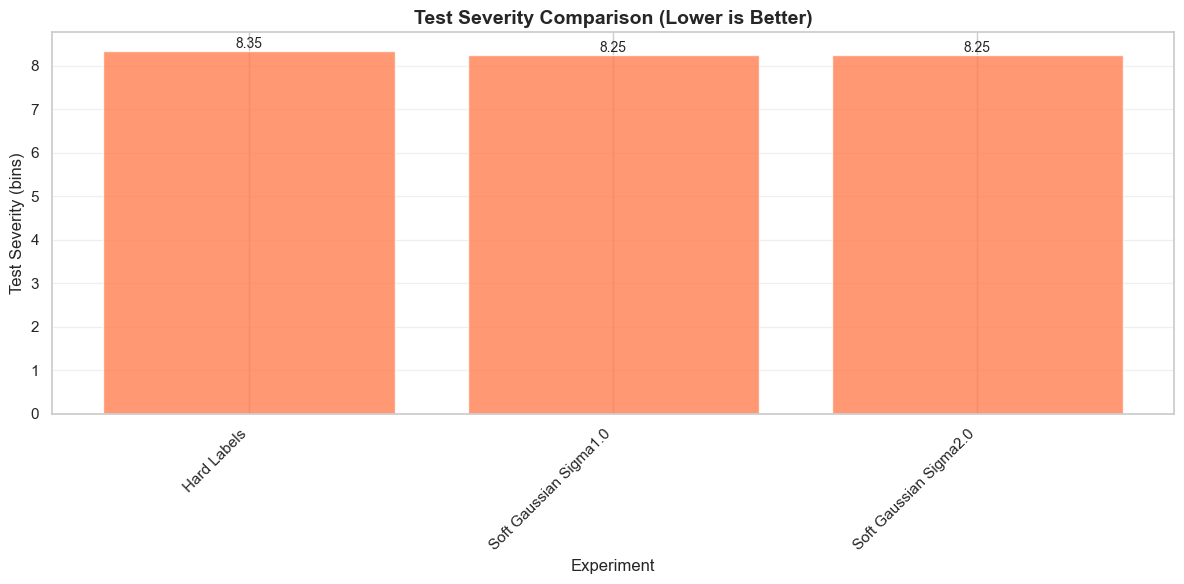

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

exp_names_sev = []
trans_sevs = []

for exp_name, exp_data in experiments.items():
    if exp_data["transition"] and "test_severity" in exp_data["transition"]:
        sev = exp_data["transition"]["test_severity"]
        if isinstance(sev, (int, float)):  # Skip "N/A"
            exp_names_sev.append(exp_name.replace("_", " ").title())
            trans_sevs.append(sev)

if trans_sevs:  # Only plot if we have severity data
    x = np.arange(len(exp_names_sev))
    bars = ax.bar(x, trans_sevs, alpha=0.8, color='coral')

    ax.set_xlabel('Experiment', fontsize=12)
    ax.set_ylabel('Test Severity (bins)', fontsize=12)
    ax.set_title('Test Severity Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names_sev, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig('results/comparison_severity.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No severity data found. Run soft-label experiments first.")

## 5. Training Curves Comparison

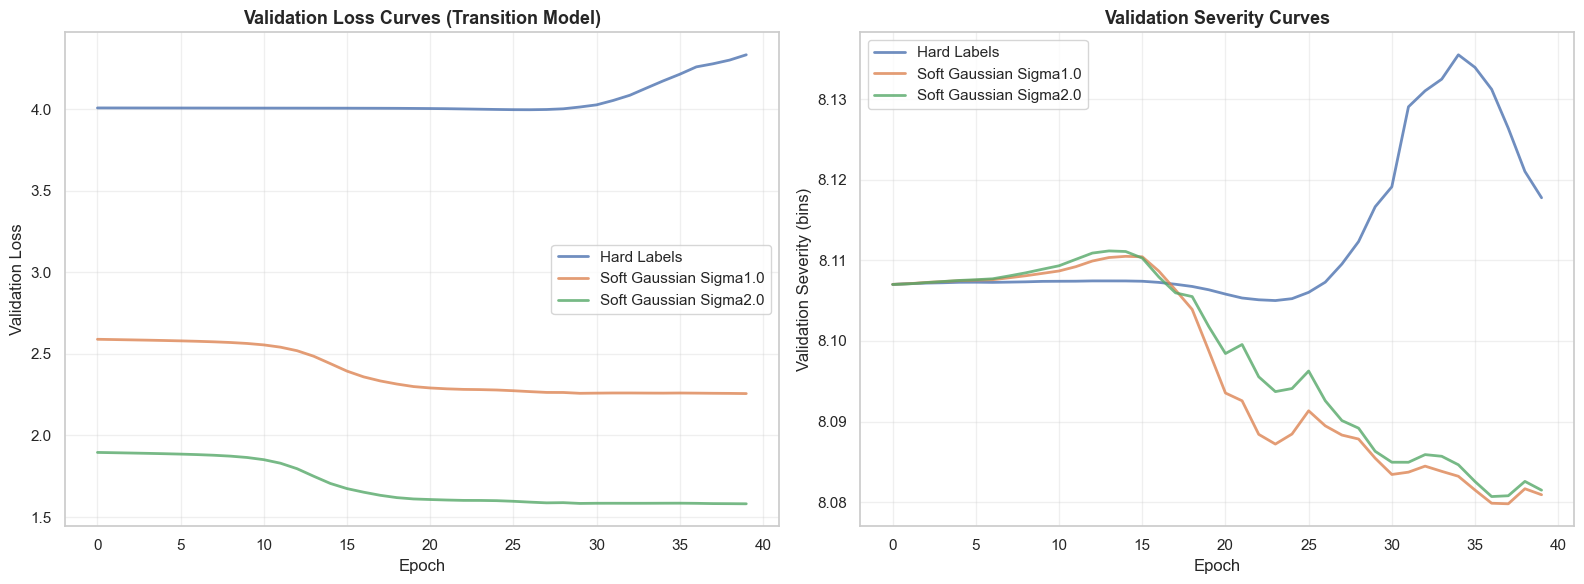

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Validation loss over epochs
for exp_name, exp_data in experiments.items():
    if exp_data["transition"]:
        val_losses = exp_data["transition"]["val_losses"]
        label = exp_name.replace("_", " ").title()
        axes[0].plot(val_losses, label=label, linewidth=2, alpha=0.8)

axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Validation Loss', fontsize=12)
axes[0].set_title('Validation Loss Curves (Transition Model)', fontsize=13, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Plot 2: Validation severity over epochs (if available)
has_severity = False
for exp_name, exp_data in experiments.items():
    if exp_data["transition"] and "val_severities" in exp_data["transition"]:
        val_sevs = exp_data["transition"]["val_severities"]
        if val_sevs:  # Check if not empty
            label = exp_name.replace("_", " ").title()
            axes[1].plot(val_sevs, label=label, linewidth=2, alpha=0.8)
            has_severity = True

if has_severity:
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Severity (bins)', fontsize=12)
    axes[1].set_title('Validation Severity Curves', fontsize=13, fontweight='bold')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No severity data available\n(Run soft-label experiments)',
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.savefig('results/comparison_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Improvement Analysis

In [ ]:
# Find hard labels baseline
hard_labels_exp = experiments.get("hard_labels")

if hard_labels_exp and hard_labels_exp["transition"]:
    hl_trans = hard_labels_exp["transition"]
    hl_base = hard_labels_exp.get("baseline") or {}
    
    hl_acc = hl_trans["test_acc"]
    hl_sev = hl_trans.get("test_severity")
    hl_base_acc = hl_base.get("test_acc")
    hl_base_sev = hl_base.get("test_severity")
    
    print("\n" + "="*80)
    print("IMPROVEMENT ANALYSIS")
    print("="*80)
    
    # Print all experiments uniformly
    for exp_name, exp_data in experiments.items():
        trans = exp_data["transition"]
        base = exp_data.get("baseline") or {}
        if not trans:
            continue
        
        print(f"\n--- {exp_name} ---")
        
        # Transition model
        acc = trans["test_acc"]
        sev = trans.get("test_severity")
        print(f"  Transition Model:")
        print(f"    Test Loss:     {trans['test_loss']:.4f}")
        if exp_name != "hard_labels":
            print(f"    Test Acc:      {acc*100:.2f}%  ({(acc - hl_acc)*100:+.2f}pp vs hard labels)")
        else:
            print(f"    Test Acc:      {acc*100:.2f}%")
        if sev is not None and isinstance(sev, (int, float)):
            if exp_name != "hard_labels" and hl_sev is not None:
                print(f"    Test Severity: {sev:.2f} bins  ({sev - hl_sev:+.2f} vs hard labels)")
            else:
                print(f"    Test Severity: {sev:.2f} bins")
        
        # Baseline model
        base_acc = base.get("test_acc")
        base_sev = base.get("test_severity")
        if base_acc is not None:
            print(f"  Baseline Model:")
            print(f"    Test Loss:     {base['test_loss']:.4f}")
            if exp_name != "hard_labels" and hl_base_acc is not None:
                print(f"    Test Acc:      {base_acc*100:.2f}%  ({(base_acc - hl_base_acc)*100:+.2f}pp vs hard labels)")
            else:
                print(f"    Test Acc:      {base_acc*100:.2f}%")
            if base_sev is not None and isinstance(base_sev, (int, float)):
                if exp_name != "hard_labels" and hl_base_sev is not None:
                    print(f"    Test Severity: {base_sev:.2f} bins  ({base_sev - hl_base_sev:+.2f} vs hard labels)")
                else:
                    print(f"    Test Severity: {base_sev:.2f} bins")
            else:
                print(f"    Test Severity: N/A  (re-run hard_labels experiment to generate)")
    
    print("\n" + "="*80)
else:
    print("\nNo hard_labels experiment found. Run the baseline first.")

## 7. Save Comparison Summary

In [24]:
# Save summary table to CSV
summary_df.to_csv('results/experiment_summary.csv', index=False)
print("✓ Summary table saved to results/experiment_summary.csv")

# Save comparison report
with open('results/comparison_report.txt', 'w') as f:
    f.write("EXPERIMENT COMPARISON REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(summary_df.to_string(index=False))
    f.write("\n\n")
    
    if hard_labels_exp and hard_labels_exp["transition"]:
        baseline_acc = hard_labels_exp["transition"]["test_acc"]
        f.write("IMPROVEMENT vs BASELINE\n")
        f.write("=" * 80 + "\n")
        f.write(f"Baseline (hard labels): {baseline_acc*100:.2f}%\n\n")
        
        for exp_name, exp_data in experiments.items():
            if exp_name != "hard_labels" and exp_data["transition"]:
                acc = exp_data["transition"]["test_acc"]
                acc_diff = (acc - baseline_acc) * 100
                f.write(f"{exp_name}: {acc*100:.2f}% ({acc_diff:+.2f}pp)\n")

print("✓ Comparison report saved to results/comparison_report.txt")

✓ Summary table saved to results/experiment_summary.csv
✓ Comparison report saved to results/comparison_report.txt
